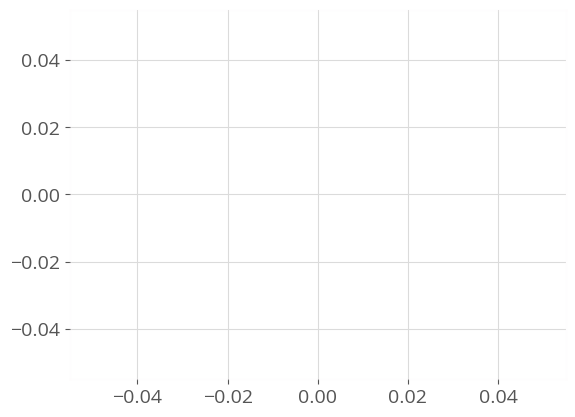

In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

0-element Array{Any,1}

In [1]:
using DataFrames, CSV, PyPlot, PorousMaterials

PyPlot.matplotlib.font_manager.fontManager.addfont("OpenSans-Regular.ttf")
# PyPlot.matplotlib.font_manager.fontManager.addfont("Abel-Regular.ttf")
PyPlot.matplotlib.style.use("grandbudapest.mplstyle")

plot()

# methane adsorption HKUST-1 and IRMOF-1
read in adsorption data, covert uptake to mmol/g

In [2]:
mofs = ["HKUST-1", "IRMOF-1"]
df = Dict{String, DataFrame}()
for mof in mofs
    df[mof] = CSV.read(joinpath("..", "adsorption_data", "ch4_" * mof * "_25C.csv"), comment="#")
    df[mof][!, :m_mmol_g] = df[mof][:, Symbol("N(cm3/g)")] / 22.4
    df[mof][!, :g_g] = df[mof][!, :m_mmol_g] * 16.04 / 1000
end
first(df[mofs[1]], 3)

,P(bar),N(cm3/g),m_mmol_g,g_g
,Float64,Float64,Float64,Float64
1,0.68,15.52,0.692857,0.0111134
2,1.72,34.43,1.53705,0.0246543
3,3.55,62.79,2.80313,0.0449621


fit Langmuir model

In [3]:
params = Dict(mof => fit_adsorption_isotherm(df[mof], Symbol("P(bar)"), :g_g, :langmuir) for mof in mofs)

Dict{String,Dict{String,Float64}} with 2 entries:
  "HKUST-1" => Dict("M"=>0.267528,"K"=>0.0600262,"MSE"=>1.1954e-6)
  "IRMOF-1" => Dict("M"=>0.517215,"K"=>0.0139932,"MSE"=>8.29801e-6)

In [4]:
f(p::Float64, mof::String) = params[mof]["M"] * params[mof]["K"] * p ./ (1 .+ params[mof]["K"] * p)
g(m::Float64, mof::String) = m / (params[mof]["K"] * (params[mof]["M"] - m)) # inverse

g (generic function with 1 method)

In [5]:
mof_to_color = Dict("IRMOF-1" => "C0", "HKUST-1" => "C3")
function draw_axes()
    axvline(x=0, color="0.6", zorder=1)
    axhline(y=0, color="0.6", zorder=1)
end

function draw_axes(ax)
    ax.axvline(x=0, color="0.6", zorder=1)
    ax.axhline(y=0, color="0.6", zorder=1)
end

draw_axes (generic function with 2 methods)

plot data with Langmuir fit

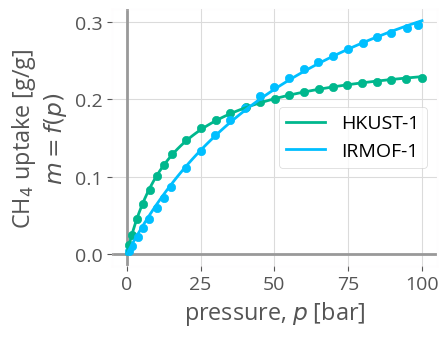

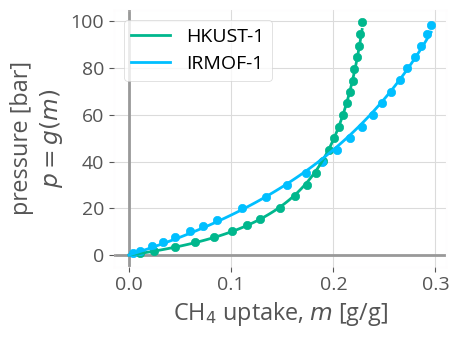

In [6]:
figure(figsize=[6.4, 4.8] * 0.75)
p = range(0.0, 100.0, length=100)
for mof in mofs
    scatter(df[mof][:, Symbol("P(bar)")], df[mof][:, :g_g], color=mof_to_color[mof], zorder=100)
    plot(p, f.(p, mof), label=mof, color=mof_to_color[mof], zorder=100)
end
draw_axes()
legend()
xlabel(L"pressure, $p$ [bar]")
ylabel(L"CH$_4$ uptake [g/g]" * "\n" * L"$m=f(p)$")
tight_layout()
savefig("methane_adsorption.pdf", format="pdf")

figure(figsize=[6.4, 4.8] * 0.75)
for mof in mofs
    m = range(0.0, maximum(df[mof][:, :g_g]), length=100)
    scatter(df[mof][:, :g_g], df[mof][:, Symbol("P(bar)")], color=mof_to_color[mof], zorder=100)
    plot(m, g.(m, mof), label=mof, color=mof_to_color[mof], zorder=100)
end
draw_axes()
legend()
xlabel(L"CH$_4$ uptake, $m$ [g/g]")
ylabel("pressure [bar]" * "\n" * L"$p=g(m)$")
tight_layout()
savefig("g.pdf", format="pdf")

# illustrate $\delta m$

Rachel: put $\kappa(P)$ and $\kappa(m)$ for inverse problem here.

In [7]:
δm = 16.04 / 1000
δ_colors = ["C1", "C2"]

2-element Array{String,1}:
 "C1"
 "C2"

In [8]:
ms = [4.0 * 16.04 / 1000, 13.0 * 16.04 / 1000]

figure()
p = range(0.0, 100.0, length=100)
mof = "HKUST-1"
scatter(df[mof][:, Symbol("P(bar)")], df[mof][:, :g_g], zorder=1000, 
    clip_on=false, color=mof_to_color[mof])
plot(p, params[mof]["M"] * params[mof]["K"] * p ./ (1 .+ params[mof]["K"] * p), 
    label=mof, zorder=1000, clip_on=false, color=mof_to_color[mof])
for (i, m) in enumerate(ms)
    p = g(m, mof)
    plot([p, p], [0, m], color=δ_colors[1])
    plot([0, p], [m, m], color=δ_colors[1])
    m_low = m - δm
    m_high = m + δm
    p_low = g(m_low, mof)
    p_high = g(m_high, mof)
    plot([p_low, p_low], [0, m_low], linestyle="--", color=δ_color)
    plot([0, p_low], [m_low, m_low], linestyle="--", color=δ_color)
    plot([p_high, p_high], [0, m_high], linestyle="--", color=δ_color)
    plot([0, p_high], [m_high, m_high], linestyle="--", color=δ_color)
    
    ps = range(p_low, p_high, length=200)
    fill_between(ps, [m_high for _ = 1:length(ps)], alpha=0.2, color=δ_color)
    fill_between([0.0, p_low], [m_low, m_low], [m_high, m_high], alpha=0.2, color=δ_color)
    if i == 2
        arrow_dx = 2
        arrow_dy = 0.4 * 0.015
        arrow(0.0, m, 0.0, δm, length_includes_head=true,
          head_width=arrow_dx, head_length=arrow_dy, clip_on=false, color="k", zorder=100)
        arrow(0.0, m+δm, 0.0, -δm, length_includes_head=true,
          head_width=arrow_dx, head_length=arrow_dy, clip_on=false, color="k", zorder=100)
        text(1.0, m + δm / 2, L"$\delta m$", verticalalignment="center")
        
        arrow(p, 0.0, p_high-p, 0.0, length_includes_head=true,
          head_width=arrow_dy, head_length=arrow_dx, clip_on=false, color="k", zorder=100)
        arrow(p_high, 0.0, p-p_high, 0.0, length_includes_head=true,
          head_width=arrow_dy, head_length=arrow_dx, clip_on=false, color="k", zorder=100)
        text(p + (p_high-p)/2, 0.75 * 0.015, L"$\delta p$", horizontalalignment="center")
    end
end
draw_axes()
# xlim(xmin=0.0)
#ylim([0.0, 20.0])
xlabel(L"pressure, $p$ [bar]")
ylabel(L"CH$_4$ adsorption, $m=f(p)$ [g/g]")

UndefVarError: UndefVarError: δ_color not defined

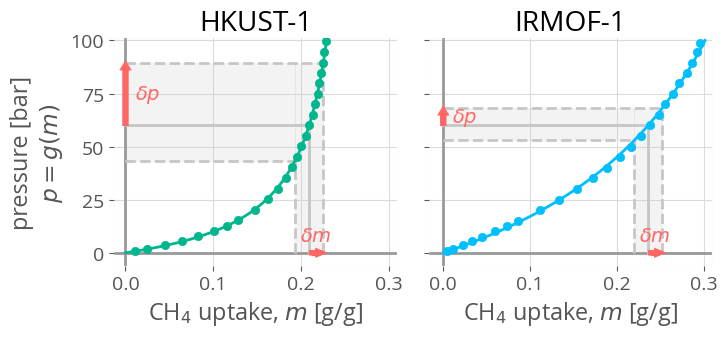

mof = "HKUST-1"
m̄ = 0.20938927354775191
For p̄ = 60.0 HKUST-1 δp = 29.208246120701745
mof = "IRMOF-1"
m̄ = 0.2360573636549906
For p̄ = 60.0 IRMOF-1 δp = 7.953723990842093


In [30]:
#figure 1
fig, axs = subplots(1, 2, figsize=[10, 4.8] * 0.75, sharey=true)
p = range(0.0, 100.0, length=100)
p̄ = [5.0, 60.0]
y_max = 0.31
δ_colors = ["C6", "C6"]
for (i, mof) in enumerate(mofs)
    m = range(0.0, 1.02 * maximum(df[mof][:, :g_g]), length=100)
    axs[i].scatter(df[mof][:, :g_g], df[mof][:, Symbol("P(bar)")], color=mof_to_color[mof], zorder=100)
    axs[i].plot(m, g.(m, mof), label=mof, color=mof_to_color[mof], zorder=100)
    axs[i].set_title(mof)
    axs[i].set_xlabel(L"CH$_4$ uptake, $m$ [g/g]")
    
    for j in [2]
        # find average m for this p
        m̄ = f(p̄[j], mof)
        @show mof
        @show m̄
        axs[i].plot([0, m̄], [p̄[j], p̄[j]], color=δ_colors[j])
        axs[i].plot([m̄, m̄], [0, p̄[j]], color=δ_colors[j])
    
        m_high = m̄ + δm
        p_high = g(m_high, mof)
        m_low = m̄ - δm
        p_low = g(m_low, mof)
        
        max_δp = max(p̄[j] - p_low, p_high - p̄[j])
        print("For p̄ = ", p̄[j], " ", mof, " δp = ", max_δp, '\n')
       
        axs[i].plot([0, m_low], [p_low, p_low], linestyle="--", color=δ_colors[j])
        axs[i].plot([m_low, m_low], [0, p_low], linestyle="--", color=δ_colors[j])
        axs[i].plot([0, m_high], [p_high, p_high], linestyle="--", color=δ_colors[j])
        axs[i].plot([m_high, m_high], [0, p_high], linestyle="--", color=δ_colors[j])
    
        ms = range(m_low, m_high, length=200)
        axs[i].fill_between(ms, [p_high for _ = 1:length(ms)], alpha=0.2, color=δ_colors[j])
        axs[i].fill_between([0.0, m_low], [p_low, p_low], [p_high, p_high], alpha=0.2, color=δ_colors[j])
        δpδm_color = "C5"
        if j == 2
            arrow_dy = 100 * 0.01
            arrow_dx = 0.3 * 0.01
            axs[i].arrow(m̄+arrow_dx, 0.0, δm-arrow_dx*2, 0.0, 
                  linewidth=4, length_includes_head=true,
                  head_width=arrow_dy, head_length=arrow_dx,
                  clip_on=false, zorder=100, color=δpδm_color)
#             axs[i].hlines(0.0, m̄, m̄ + δm, linewidth=4, zorder=100, color=δpδm_color)
#             axs[i].vlines(0.0, p̄[j], p_high, linewidth=4, zorder=100, color=δpδm_color)
            axs[i].arrow(0.0, p̄[j]+arrow_dy, 0.0, max_δp-arrow_dy*2,
                  linewidth=4, length_includes_head=true,
                  head_width=arrow_dx, head_length=arrow_dy,
                  clip_on=false, zorder=100, color=δpδm_color)
            axs[i].text(m̄ + δm/2, 8.0, L"$\delta m$", va="center", ha="center", color=δpδm_color)
            axs[i].text(0.025, p̄[j] + max_δp/2, L"$\delta p$", ha="center", va="center", color=δpδm_color)
        end 
    end 
    axs[i].set_xlim(xmax=0.31)
    axs[i].set_ylim(ymax=101)
    draw_axes(axs[i])
end
axs[1].set_ylabel("pressure [bar]" * "\n" * L"$p=g(m)$")
tight_layout()
savefig("compare_conditioning_g.pdf", format="pdf")

For p̄ = 60.0 HKUST-1 δp = 29.208246120701745
For p̄ = 

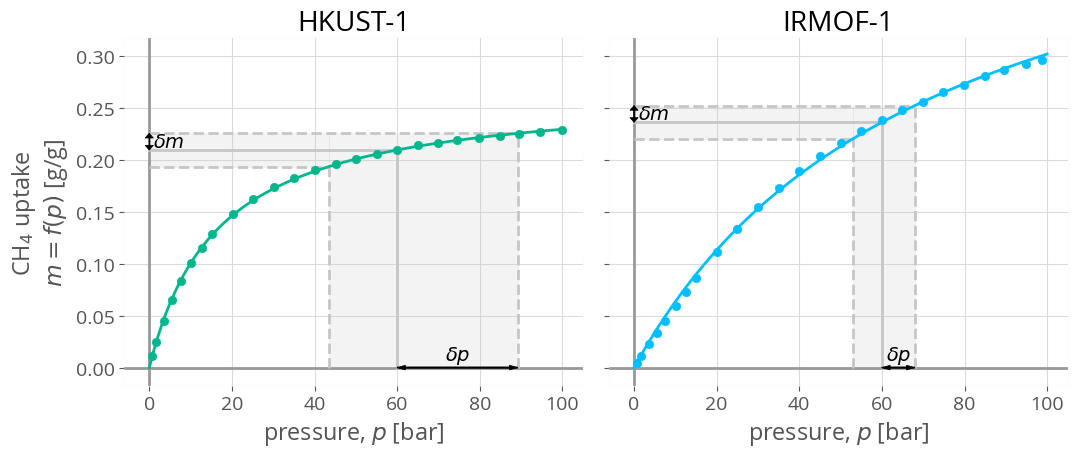

60.0 IRMOF-1 δp = 7.953723990842093


In [10]:
#figure 1, compare conditioning WRT g.
fig, axs = subplots(1, 2, figsize=[11, 4.8], sharey=true)
p = range(0.0, 100.0, length=100)
p̄ = [5.0, 60.0]
y_max = 0.31

for (i, mof) in enumerate(mofs)    
    axs[i].scatter(df[mof][:, Symbol("P(bar)")], df[mof][:, :g_g], 
        color=mof_to_color[mof], zorder=2003, clip_on=false)
    axs[i].plot(p, f.(p, mof), color=mof_to_color[mof], zorder=1000)
    axs[i].set_title(mof)    
    
    for j in [2]
        m̄ = f(p̄[j], mof)
        axs[i].plot([p̄[j], p̄[j]], [0, m̄], color=δ_colors[j])
        axs[i].plot([0, p̄[j]], [m̄, m̄], color=δ_colors[j])
    
        m_high = m̄ + δm
        p_high = g(m_high, mof)
        m_low = m̄ - δm
        p_low = g(m_low, mof)
        
        max_δp = max(p̄[j] - p_low, p_high - p̄[j])
        print("For p̄ = ", p̄[j], " ", mof, " δp = ", max_δp, '\n')
       
        axs[i].plot([p_low, p_low], [0, m_low], linestyle="--", color=δ_colors[j])
        axs[i].plot([0, p_low], [m_low, m_low], linestyle="--", color=δ_colors[j])
        axs[i].plot([p_high, p_high], [0, m_high], linestyle="--", color=δ_colors[j])
        axs[i].plot([0, p_high], [m_high, m_high], linestyle="--", color=δ_colors[j])
    
        ps = range(p_low, p_high, length=200)
        axs[i].fill_between(ps, [m_high for _ = 1:length(ps)], alpha=0.2, color=δ_colors[j])
        axs[i].fill_between([0.0, p_low], [m_low, m_low], [m_high, m_high], alpha=0.2, color=δ_colors[j])
        if j == 2
            arrow_dx = 2
            arrow_dy = 0.3 * 0.015
            axs[i].arrow(0.0, m̄, 0.0, δm, length_includes_head=true,
              head_width=arrow_dx, head_length=arrow_dy, clip_on=false, color="k", zorder=100)
            axs[i].arrow(0.0, m̄+δm, 0.0, -δm, length_includes_head=true,
              head_width=arrow_dx, head_length=arrow_dy, clip_on=false, color="k", zorder=100)
            axs[i].text(1.0, m̄ + δm / 2, L"$\delta m$", verticalalignment="center")

            axs[i].arrow(p̄[j], 0.0, p_high-p̄[j], 0.0, length_includes_head=true,
              head_width=arrow_dy, head_length=arrow_dx, clip_on=false, color="k", zorder=100)
            axs[i].arrow(p_high, 0.0, p̄[j]-p_high, 0.0, length_includes_head=true,
              head_width=arrow_dy, head_length=arrow_dx, clip_on=false, color="k", zorder=100)
            axs[i].text(p̄[j] + (p_high-p̄[j])/2, 0.5 * 0.015, L"$\delta p$", horizontalalignment="center")
            axs[i].set_xlabel(L"pressure, $p$ [bar]")
        end 
    end 
#     axs[i].set_xlim([0, 102])
#     axs[i].set_ylim([-0.001, y_max])
    draw_axes(axs[i])
end
axs[1].set_ylabel(L"CH$_4$ uptake" * "\n" * L"$m=f(p)$ [g/g]")
tight_layout()
savefig("compare_conditioning_g.pdf", format="pdf")

# $\kappa(p)$

In [54]:
#absolute error in predicted gas comp. over absolute error in data
ξ_of_m(m::Float64, mof::String) = params[mof]["M"] / (params[mof]["K"] * (params[mof]["M"] - m) ^ 2)  # inverse kappa with respect to m
ξ_of_p(p::Float64, mof::String) = (1 + params[mof]["K"] * p)^2 / (params[mof]["K"] * params[mof]["M"]) # inverse kappa with respect to p   

ξ_of_p (generic function with 1 method)

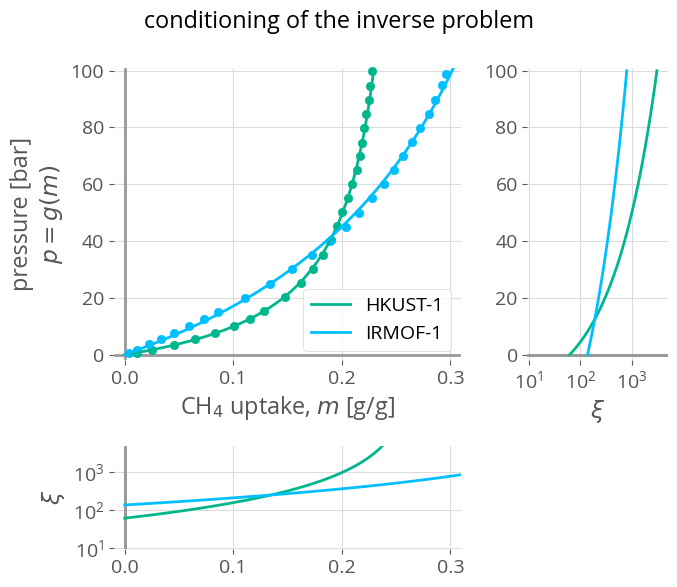

┌ Warning: fix axes!
└ @ Main In[86]:45


In [86]:
#figure 2
p = range(0.0, 100.0, length=100)

fig = figure(figsize=(7, 6))
ax1 = subplot2grid((3, 3), (0, 0), colspan=2, rowspan=2)
ax2 = subplot2grid((3, 3), (0, 2), colspan=1, rowspan=2)
ax3 = subplot2grid((3, 3), (2, 0), colspan=2, rowspan=1)
tight_layout()

ax1.set_xlabel(L"CH$_4$ uptake, $m$ [g/g]")
ax1.set_ylabel("pressure [bar]" * "\n" * L"$p=g(m)$")
ax1.set_ylim([-2, 101])
ax1.set_xlim([-0.01, 0.31])
draw_axes(ax1)

for mof in mofs
    m = range(0.0, 1.1 * maximum(df[mof][:, :g_g]), length=100)
    
    # g(m)
    ax1.scatter(df[mof][:, :g_g], df[mof][:, Symbol("P(bar)")], color=mof_to_color[mof], zorder=100, clip_on=false)
    ax1.plot(m, g.(m, mof), label=mof, color=mof_to_color[mof], zorder=100)
    
    ξ_lims = [9.5, 5000]
    # ξ(m)
    ax3.plot(m, ξ_of_m.(m, mof), color=mof_to_color[mof])
    ax3.set_yscale("log")
    ax3.set_yticks([10,100,1000])
    ax3.set_ylim(ξ_lims)
    ax3.set_xlim(ax1.get_xlim())
    ax3.axvline(x=0, color="0.6", zorder=1)
    ax3.set_ylabel(L"$\xi$")
    
    # ξ(p)
    p = range(0.0, 100.0, length=100)
    ax2.plot(ξ_of_p.(p, mof), p, color=mof_to_color[mof])
    ax2.set_xscale("log")
    ax2.set_xticks([10,100,1000])
    ax2.set_xlim(ξ_lims)
    ax2.axhline(y=0, color="0.6", zorder=1)
    ax2.set_xlabel(L"$\xi$")
    ax2.set_ylim(ax1.get_ylim())
end
ax1.legend()

@warn "fix axes!"
suptitle("conditioning of the inverse problem")

tight_layout()
#savefig("$mof.pdf", format="pdf", dpi=600, bbox_inches="tight")

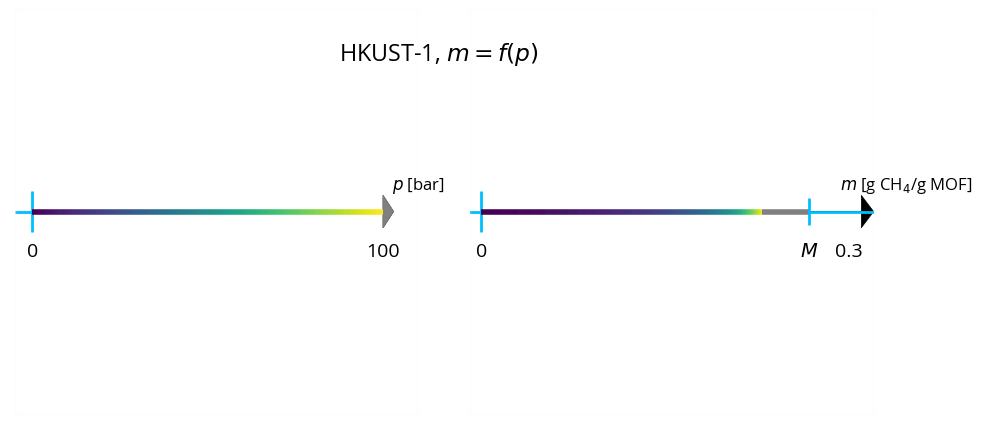

In [14]:
mof = "HKUST-1"

fig, axs = subplots(1, 2, figsize=(10, 5), sharey=true)

# Set up line segment with arrow head
bar_height = 1
function set_axes(p_axis::Int64, m_axis::Int64)
    axs[p_axis].set_xlim(-5, 110)
    axs[p_axis].arrow(0.0, 0.0, 100.0, 0.0, head_width=0.8, head_length=3, color="black", clip_on=false)
    axs[p_axis].text(100, -bar_height * 1.1, 100, horizontalalignment="center")
    axs[p_axis].set_ylabel(L"$p$ [bar]", fontsize=12, rotation=0, color="black")
    axs[p_axis].yaxis.set_label_coords(1.0, 0.54)
    axs[m_axis].set_xlim(-0.009, 0.32)
    axs[m_axis].arrow(0.0, 0.0, 0.31, 0.0, head_width=0.8, head_length=0.01, color="black", clip_on=false)
    axs[m_axis].text(0.3, -bar_height * 1.1, 0.3, horizontalalignment="center")
    axs[m_axis].set_ylabel(L"$m$ [g CH$_4$/g MOF]", fontsize=12, rotation=0, color="black")
    axs[m_axis].yaxis.set_label_coords(1.08, 0.54)
    for i = 1:2 
        axs[i].set_ylim(-5, 5)
        axs[i].hlines(0.0, -5, 100)
        axs[i].axes.xaxis.set_ticks([])
        axs[i].axes.yaxis.set_ticks([])
        axs[i].vlines(0, - bar_height / 2., bar_height / 2., lw=2)
        axs[i].text(0, -bar_height * 1.1, 0, horizontalalignment="center")
    end
end

# Set axes labels
set_axes(1, 2)
axs[1].arrow(0.0, 0.0, 100.0, 0.0, head_width=0.8, head_length=3, color="grey",clip_on=false)

# Set colors on p 
n_lines = 100
pressures = range(0.0, 100.0, length=n_lines+1)
colors = plt.cm.viridis.(range(0, 1, length=n_lines))
for i = 1:n_lines
    axs[1].hlines(0.0, pressures[i], pressures[i+1], color=colors[i], linewidth=4)
    m_min = f(pressures[i], mof)
    m_max = f(pressures[i+1], mof)
    axs[2].hlines(0.0, m_min, m_max, color=colors[i], clip_on=false, linewidth=4)
end
axs[2].hlines(0.0, f(pressures[n_lines], mof), params[mof]["M"], color="grey", clip_on=false, linewidth=4)

axs[2].vlines(params[mof]["M"], - bar_height / 3.0, bar_height / 3.0, lw=2)
axs[2].text(params[mof]["M"], -bar_height * 1.1, L"$M$", horizontalalignment="center")
suptitle(mof * L", $m = f(p)$", x=0.45, y=0.8)
plt.tight_layout()

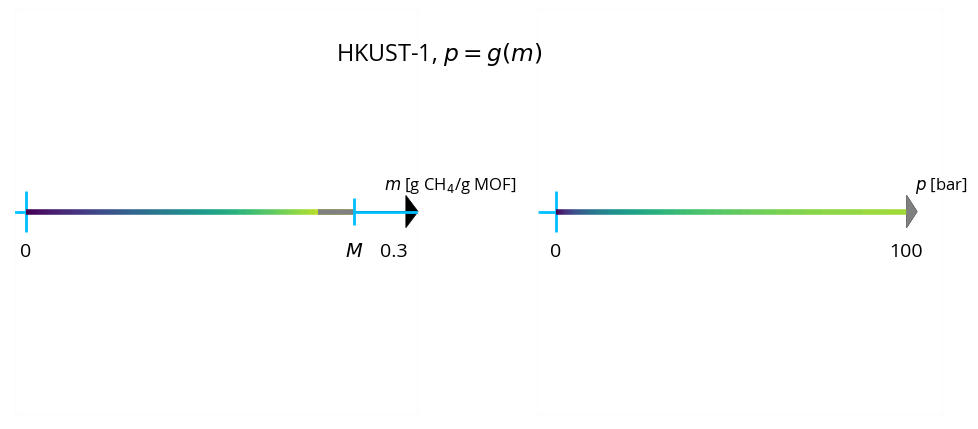

In [15]:
mof = "HKUST-1"

fig, axs = subplots(1, 2, figsize=(10, 5), sharey=true)

# Set up line segment with arrow head
set_axes(2, 1)

# Set colors on p 
n_lines = 100
masses = range(0.0, params[mof]["M"], length=n_lines+1)
colors = plt.cm.viridis.(range(0, 1, length=n_lines))
for i = 1:n_lines
    axs[1].hlines(0.0, masses[i], masses[i+1], color=colors[i], linewidth=4)
    p_min = g(masses[i], mof)
    p_max = g(masses[i+1], mof)
    if p_min <= 100
        axs[2].hlines(0.0, p_min, p_max, color=colors[i], clip_on=false, linewidth=4)
    end
end

#make end of m line grey
axs[1].hlines(0.0, masses[n_lines-10], params[mof]["M"], color="grey", linewidth=4)

axs[1].vlines(params[mof]["M"], - bar_height / 3.0, bar_height / 3.0, lw=2)
axs[1].text(params[mof]["M"], -bar_height * 1.1, L"$M$", horizontalalignment="center")
axs[2].arrow(99.9, 0.0, 0.10, 0.0, head_width=0.8, head_length=3, color="grey", clip_on=false, zorder=1000)
suptitle(mof * L", $p = g(m)$", x=0.45, y=0.8)
plt.tight_layout()
savefig("HKUST1_1D.pdf", format="pdf", bbox_inches="tight")